### Grizli spectral products and fitting tools ###
   

In [1]:
%matplotlib inline

In [2]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt

import astropy.io.fits as pyfits
import drizzlepac

import grizli
from grizli import utils, multifit
print(grizli.__version__)

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol
1.0.dev1458


**NB:** The example below uses the "ERS" exposures pre-processed as described in the `Grizli-Pipeline` notebook.

In [4]:
os.getcwd()
root = 'j033216m2743'
os.chdir('/tmp/grizli/{0}/Extractions'.format(root)) 

grp = multifit.GroupFLT(grism_files=glob.glob('*GrismFLT.fits'), 
                        catalog='{0}-ir.cat.fits'.format(root), 
                        cpu_count=-1, sci_extn=1, pad=256)

Load ib6o23rsq.01.GrismFLT.fits!
Load ib6o21qmq.01.GrismFLT.fits!
Load ib6o23ruq.01.GrismFLT.fits!
Load ib6o21r6q.01.GrismFLT.fits!
Load ib6o21qoq.01.GrismFLT.fits!
Load ib6o23ryq.01.GrismFLT.fits!
Load ib6o21r8q.01.GrismFLT.fits!
Load ib6o23s0q.01.GrismFLT.fits!
Files loaded - 9.11 sec.


Now provide two ways of saving the extracted 2D spectra of a given object:  "beams" cutouts from the FLT files and drizzled combinations of them, combined for the available grisms separately and for combinations of the available PAs.

In [5]:
# Fitting templates

# First is set with combined emission line complexes for the redshift fit 
# (don't allow infinite freedom) of the line ratios / fluxes
templ0 = grizli.utils.load_templates(fwhm=1200, line_complexes=True, stars=False, 
                                     full_line_list=None,  continuum_list=None, 
                                     fsps_templates=True)

# Second set has individual line templates for fitting the line fluxes
templ1 = grizli.utils.load_templates(fwhm=1200, line_complexes=False, stars=False, 
                                     full_line_list=None, continuum_list=None, 
                                     fsps_templates=True)

# Show the template names / dictionary keys
fmt = '{0:<36s} {1:<36s}'
print(fmt.format('templ0', 'templ1'))
print(fmt.format('------', '------'))

for i in range(len(templ1)):
    if i > len(templ0)-1:
        print(fmt.format('', list(templ1.keys())[i]))
    else:
        print(fmt.format(list(templ0.keys())[i], list(templ1.keys())[i]))

# Parameters for drizzled line maps
pline = {'kernel': 'point', 'pixfrac': 0.2, 'pixscale': 0.1, 'size': 8, 'wcs': None}

templ0                               templ1                              
------                               ------                              
fsps/fsps_QSF_12_v3_nolines_001.dat  fsps/fsps_QSF_12_v3_nolines_001.dat 
fsps/fsps_QSF_12_v3_nolines_002.dat  fsps/fsps_QSF_12_v3_nolines_002.dat 
fsps/fsps_QSF_12_v3_nolines_003.dat  fsps/fsps_QSF_12_v3_nolines_003.dat 
fsps/fsps_QSF_12_v3_nolines_004.dat  fsps/fsps_QSF_12_v3_nolines_004.dat 
fsps/fsps_QSF_12_v3_nolines_005.dat  fsps/fsps_QSF_12_v3_nolines_005.dat 
fsps/fsps_QSF_12_v3_nolines_006.dat  fsps/fsps_QSF_12_v3_nolines_006.dat 
fsps/fsps_QSF_12_v3_nolines_007.dat  fsps/fsps_QSF_12_v3_nolines_007.dat 
fsps/fsps_QSF_12_v3_nolines_008.dat  fsps/fsps_QSF_12_v3_nolines_008.dat 
fsps/fsps_QSF_12_v3_nolines_009.dat  fsps/fsps_QSF_12_v3_nolines_009.dat 
fsps/fsps_QSF_12_v3_nolines_010.dat  fsps/fsps_QSF_12_v3_nolines_010.dat 
fsps/fsps_QSF_12_v3_nolines_011.dat  fsps/fsps_QSF_12_v3_nolines_011.dat 
fsps/fsps_QSF_12_v3_nolines_012.dat  f

In [6]:
### Find IDs of specific objects to extract (2 galaxies and a star)
import astropy.units as u
tab = utils.GTable()
tab['ra'] = [53.0657456, 53.0624459, 53.077048]
tab['dec'] = [-27.720518, -27.707018, -27.705928]

idx, dr = grp.catalog.match_to_catalog_sky(tab)
source_ids = grp.catalog['NUMBER'][idx]
tab['id'] = source_ids
tab['dr'] = dr.to(u.mas)
tab['dr'].format='.1f'

j033216m2743_00155.beams.fits


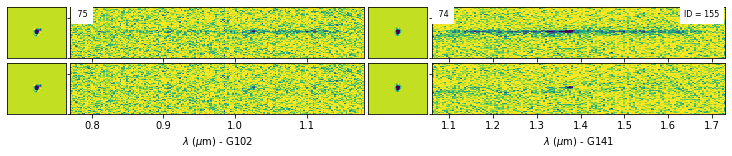

In [7]:
id = source_ids[0]

# Pull out the 2D cutouts
beams = grp.get_beams(id, size=80)
mb = multifit.MultiBeam(beams, fcontam=0.2, group_name=root, psf=False)

# Save a FITS file with the 2D cutouts (beams) from the individual exposures
mb.write_master_fits()

# Fit polynomial model for initial continuum subtraction
wave = np.linspace(2000,2.5e4,100)
poly_templates = grizli.utils.polynomial_templates(wave, order=7)
pfit = mb.template_at_z(z=0, templates=poly_templates, fit_background=True, 
                        fitter='lstsq', get_uncertainties=2)

# Drizzle grisms / PAs and make a figure
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
                                     size=32, zfit=pfit, diff=True)

# Save drizzle figure FITS file
fig.savefig('{0}_{1:05d}.stack.png'.format(root, id))
hdu.writeto('{0}_{1:05d}.stack.fits'.format(root, id), clobber=True)

Run id=155 with fit_args.npy
j033216m2743_00155.full.fits


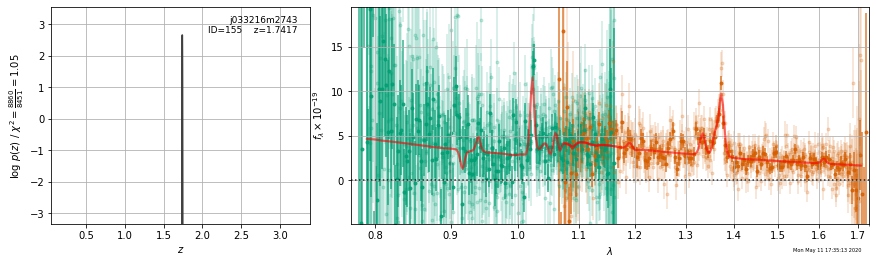

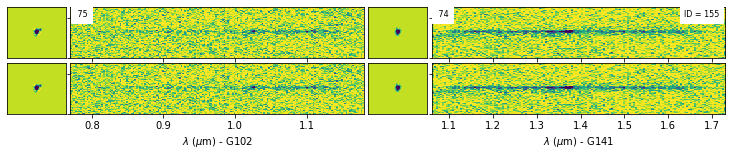

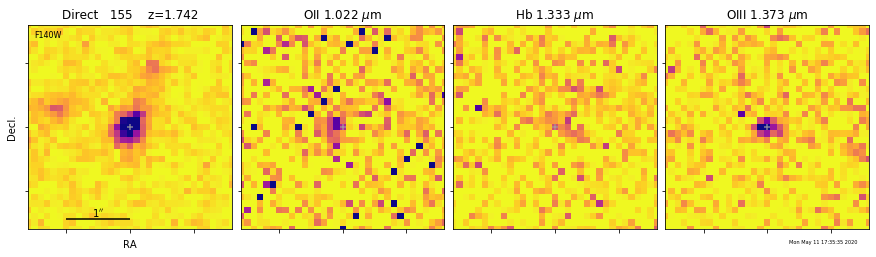

In [8]:
# High-level wrapper script for doing everything (redshift fits, line fluxes, drizzled line 
# maps).  More explanation of the details of individual steps TBD.
#
# Needs to be able to find {root}_{id:05d}.beams.fits and {root}_{id:05d}.stack.fits 
# generated above
from grizli import fitting
out = fitting.run_all_parallel(id, get_output_data=True, 
                               fit_beams=True, fit_only_beams=True, 
                               verbose=False,
                               argsfile='fit_args.npy')

In [9]:
# Products
mb, st, fit, tfit, line_hdu = out

# Objects that are used for the fitting.  They are 
# both subclasses of grizli.fitting.GroupFitter, 
# which provides the fitting methods.
print('mb: ', mb.__class__) # From "beams.fits"
print('st: ', st.__class__) # Drizzled spectra from "stack.fits" -- DEPRECATED

mb:  <class 'grizli.multifit.MultiBeam'>
st:  <class 'NoneType'>


In [10]:
# Properties of the fit on the redshift grid
# stored in an astropy.table.Table
print('Fit table:', fit.colnames)
for k in fit.meta:
    print(k, fit.meta[k])

Fit table: ['zgrid', 'chi2', 'coeffs', 'covar', 'pdf', 'risk']
N (8, 'Number of spectrum extensions')
polyord (3, 'Order polynomial fit')
chi2poly (9118.715215889588, 'Chi^2 of polynomial fit')
chi2spl (8964.147726310304, 'Chi^2 of spline fit')
Rspline (30, 'R=lam/dlam of spline fit')
kspl (36, 'Parameters, k, of spline fit')
huberdel (4, 'Huber delta parameter, see scipy.special.huber')
splf01 (0.0, 'Spline flux at 0.61 um')
sple01 (0.0, 'Spline flux err at 0.61 um')
splf02 (8.417259555274996e-19, 'Spline flux at 0.81 um')
sple02 (8.266340154765533e-19, 'Spline flux err at 0.81 um')
splf03 (3.438574101513878e-19, 'Spline flux at 0.90 um')
sple03 (1.9230996548706065e-19, 'Spline flux err at 0.90 um')
splf04 (3.3403136322959547e-19, 'Spline flux at 1.27 um')
sple04 (6.479776741641413e-20, 'Spline flux err at 1.27 um')
splf05 (2.799470334448754e-19, 'Spline flux at 1.40 um')
sple05 (5.178299663855636e-20, 'Spline flux err at 1.40 um')
NTEMP (17, 'Number of fitting templates')
DoF (8451, 

Text(0, 0.5, '$\\chi^2$')

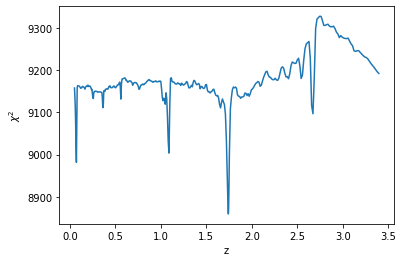

In [11]:
plt.plot(fit['zgrid'], fit['chi2'])
plt.xlabel('z'); plt.ylabel(r'$\chi^2$')

odict_keys(['cont1d', 'line1d', 'cfit', 'coeffs', 'chi2', 'covar', 'z', 'templates'])
z = 1.7416867083072538
Continuum template, cont1d:  <class 'grizli.utils.SpectrumTemplate'>


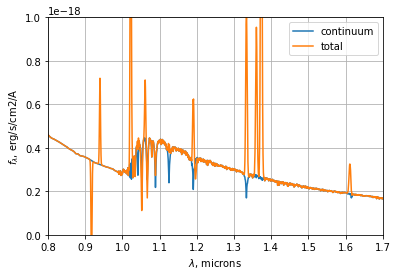

In [12]:
# Results of the fit at the best determined redshift
print(tfit.keys())
print('z = {0}'.format(tfit['z']))

print('Continuum template, cont1d: ', tfit['cont1d'].__class__)
plt.plot(tfit['cont1d'].wave/1.e4, tfit['cont1d'].flux, label='continuum')
plt.plot(tfit['line1d'].wave/1.e4, tfit['line1d'].flux, label='total')
plt.xlim(0.8, 1.7); plt.ylim(0,1.e-18); plt.grid()
plt.xlabel(r'$\lambda$, microns'); plt.ylabel(r'$f_\lambda$, erg/s/cm2/A'); plt.legend()

# cfit, coeffs, covar are coefficients of the template fit
# and their covariance

## Retrieving the fit output
All of the information above is also stored in the `*full.fits` file, so you don't have to 
retrieve the outputs directly from the fitting script.

In [13]:
fit_hdu = pyfits.open('{0}_{1:05d}.full.fits'.format(root, id)) 
fit_hdu.info()

Filename: j033216m2743_00155.full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      97   ()      
  1  ZFIT_STACK    1 BinTableHDU     92   400R x 6C   [D, D, 25D, 625D, D, D]   
  2  ZFIT_BEAM     1 BinTableHDU     87   62R x 6C   [D, D, 25D, 625D, D, D]   
  3  TEMPL         1 BinTableHDU    177   9929R x 3C   [D, D, D]   
  4  COVAR         1 ImageHDU       203   (53, 53)   float64   
  5  SEG           1 ImageHDU         8   (80, 80)   int32   
  6  DSCI        F098M ImageHDU        28   (80, 80)   float32   
  7  DWHT        F098M ImageHDU        28   (80, 80)   float32   
  8  DSCI        F140W ImageHDU        28   (80, 80)   float32   
  9  DWHT        F140W ImageHDU        28   (80, 80)   float32   
 10  LINE        OI-6302 ImageHDU        31   (80, 80)   float32   
 11  CONTINUUM   OI-6302 ImageHDU        31   (80, 80)   float32   
 12  CONTAM      OI-6302 ImageHDU        31   (80, 80)   float32   
 13  LINEWHT     OI-6302 

In [14]:
# Basic properties of the input data
fit_hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ID      =                  155 / Object ID                                      
RA      =     53.0657544026552 / Central R.A.                                   
DEC     =   -27.72050703815263 / Central Decl.                                  
PIXFRAC =                  0.2 / Drizzle PIXFRAC                                
DRIZKRNL= 'point   '           / Drizzle kernel                                 
NINPUT  =                    8 / Number of drizzled beams                       
FILE0001= 'ib6o23rsq_flt.fits' / Parent filename                                
GRIS0001= 'G141    '           / Beam grism element                             
PA0001  =                 74

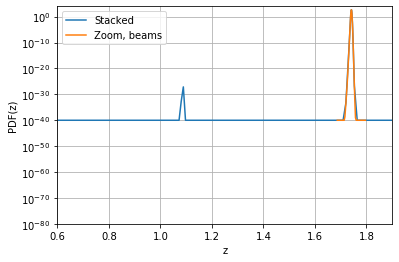

In [15]:
from astropy.table import Table

# same as the fit table above, redshift fit to the stacked spectra
fit_stack = Table(fit_hdu['ZFIT_STACK'].data) 
plt.plot(fit_stack['zgrid'], fit_stack['pdf'], label='Stacked')

# zoom in around the initial best-guess with the individual "beam" spectra
if 'ZFIT_BEAM' in fit_hdu:
    fit_beam = Table(fit_hdu['ZFIT_BEAM'].data)   
    plt.plot(fit_beam['zgrid'], fit_beam['pdf'], label='Zoom, beams')

plt.xlim(0.6, 1.9); plt.semilogy(); plt.grid()
plt.ylim(1.e-80, 1e4)
plt.xlabel('z'); plt.ylabel('PDF(z)'); plt.legend()


In [16]:
# Best-fit templates, like `tfit` above
templ = Table(fit_hdu['TEMPL'].data)
print(templ.colnames)

['wave', 'continuum', 'full']


j033216m2743_00155.full.fits has lines [OI-6302 HeI-5877 OIII Hb OIII-4363 Hg Hd H7 H8 H9 H10 NeIII-3867 OII NeVI-3426 NeV-3346 MgII]


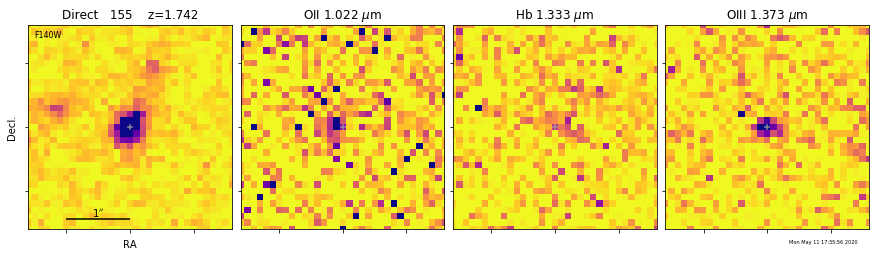

In [17]:
# Extensions 'DSCI', 'LINE', 'LINEWHT'... contain the drizzled line maps
print('{0} has lines [{1}]'.format(fit_hdu.filename(), fit_hdu[0].header['HASLINES']))

# Helper script for plotting them, not generated automatically
fig = grizli.fitting.show_drizzled_lines(fit_hdu, size_arcsec=1.6, cmap='plasma_r')
fig.savefig('{0}_{1:05d}.line.png'.format(root, id))

# Fit stellar templates to a point source

In [18]:
# Red star
id=source_ids[2]

0/1: 430 8
j033216m2743_00430.beams.fits


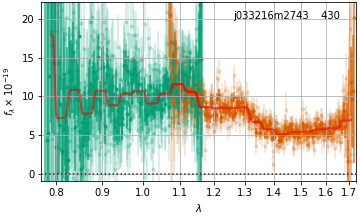

In [19]:
from grizli.pipeline import auto_script
auto_script.extract(field_root=root, ids=[id], MW_EBV=0, 
                    pline=pline, run_fit=False, grp=grp, diff=True)

from IPython.display import Image
Image(filename='{0}_{1:05d}.R30.png'.format(root, id)) 

load_master_fits: j033216m2743_00430.beams.fits
1 ib6o23rsq_flt.fits G141
2 ib6o21qmq_flt.fits G102
3 ib6o23ruq_flt.fits G141
4 ib6o21r6q_flt.fits G102
5 ib6o21qoq_flt.fits G102
6 ib6o23ryq_flt.fits G141
7 ib6o21r8q_flt.fits G102
8 ib6o23s0q_flt.fits G141
stars/M6.5.txt
stars/M8.0.txt
stars/L1.0.txt
stars/L3.5.txt
stars/L6.0.txt
stars/T2.0.txt
stars/T6.0.txt
stars/T7.5.txt

# root id ra dec chi2 chi2_flat dof nk best_template as_epsf
j033216m2743       430 53.077097 -27.706011   6296.055   6377.475       4852          7 stars/M8.0.txt       0



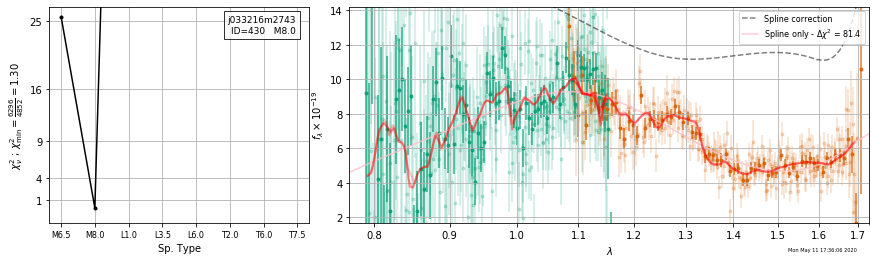

In [20]:
mb = multifit.MultiBeam('{0}_{1:05d}.beams.fits'.format(root, id), 
                    fcontam=0.2, group_name=root, psf=False, min_sens=0.05)

# Limited set of red stellar templates
tstar = grizli.utils.load_templates(fwhm=1200, line_complexes=True, 
                                    fsps_templates=True, stars=True)

# Fit spectral types.  Just makes the plot now, outputs not saved 
fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
                                 spline_correction=True, spline_args={'Rspline':5},
                                 oned_args={'bin':2})

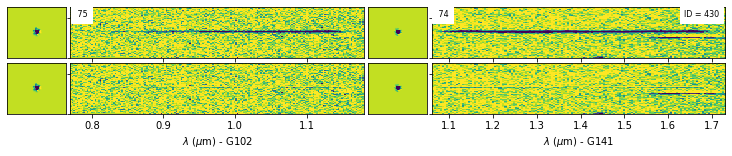

In [21]:
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
                                     size=32, zfit=tfit, diff=True)

In [22]:
# Fit for small shifts of the trace perpendicular to the dispersion
# All exposures in a given grism have the same offset
tr = mb.fit_trace_shift(verbose=False)
print('Trace offset: ', tr[0])

Trace offset:  [-0.11093706 -0.11472479]


stars/M6.5.txt
stars/M8.0.txt
stars/L1.0.txt
stars/L3.5.txt
stars/L6.0.txt
stars/T2.0.txt
stars/T6.0.txt
stars/T7.5.txt

# root id ra dec chi2 chi2_flat dof nk best_template as_epsf
j033216m2743       430 53.077097 -27.706011   5984.794   6057.538       4763          7 stars/M8.0.txt       0



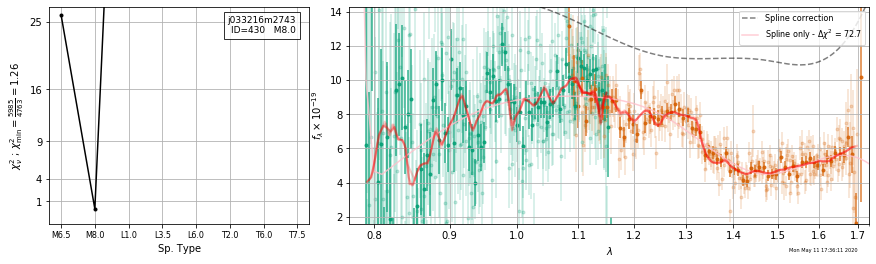

In [23]:
# Refit.  Chi-squared is a bit improved
fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
                                 spline_correction=True, spline_args={'Rspline':6}, 
                                 oned_args={'bin':2})

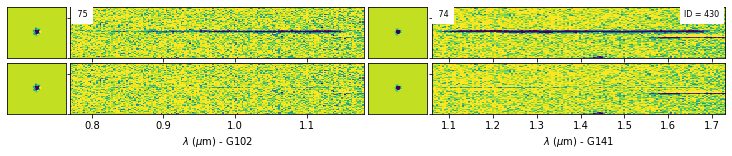

In [24]:
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
                                     size=32, zfit=tfit, diff=True)

# Use ePSF morphological model

Can sometimes get an even better morphological model for point sources using effective PSF models in place of the observed drizzled direct image.

load_master_fits: j033216m2743_00430.beams.fits
1 ib6o23rsq_flt.fits G141
2 ib6o21qmq_flt.fits G102
3 ib6o23ruq_flt.fits G141
4 ib6o21r6q_flt.fits G102
5 ib6o21qoq_flt.fits G102
6 ib6o23ryq_flt.fits G141
7 ib6o21r8q_flt.fits G102
8 ib6o23s0q_flt.fits G141
stars/M6.5.txt
stars/M8.0.txt
stars/L1.0.txt
stars/L3.5.txt
stars/L6.0.txt
stars/T2.0.txt
stars/T6.0.txt
stars/T7.5.txt

# root id ra dec chi2 chi2_flat dof nk best_template as_epsf
j033216m2743       430 53.077097 -27.706011   4354.798   4440.462       3777          7 stars/M8.0.txt       1



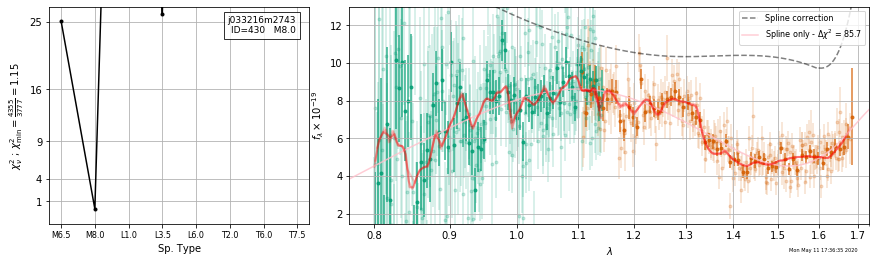

In [25]:
USE_EPSF = True

mb = multifit.MultiBeam('{0}_{1:05d}.beams.fits'.format(root, id), 
                    fcontam=0.2, group_name=root, psf=USE_EPSF, min_sens=0.05)

# Trace offset
tr = mb.fit_trace_shift(verbose=False)

# Fit spectral types.  Just makes the plot now, outputs not saved 
fig, result, tfit = mb.xfit_star(tstar=tstar, fit_background=False,
                                 spline_correction=True, spline_args={'Rspline':5},
                                 oned_args={'bin':2})

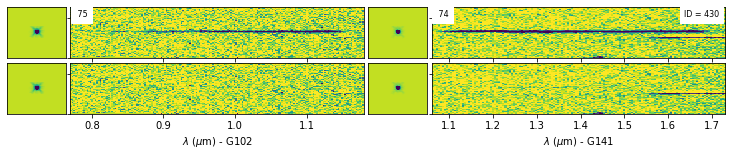

In [26]:
hdu, fig = mb.drizzle_grisms_and_PAs(fcontam=0.2, flambda=False, kernel='point', 
                                     size=32, zfit=tfit, diff=True)